In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Embedding, LSTM
from keras.datasets import mnist
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 문장을 잘라줌.
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras_preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# GPU 사용 초기화 및 할당.
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

import warnings
warnings.filterwarnings('ignore')

#### RNN(Recurrent Neural Network)
- RNN은 은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 출력층 방향으로도 보내면서, 다시 은닉층 노드의 다음 계산의 입력으로 보내는 특징.
- NLP, 필기 인식, 음성 인식, 시계열 데이터 같이 시변적 특징을 지니는 데이터를 처리하는데 적용.
- Recurrent : 이전에서 어떤 정보가 추가적으로 오는 것을 의미.

 
#### LSTM(Long Short Term Memory)
- 시간을 많이 거슬러 올라갈수록(Long term) 경사를 소실하는 문제가 발생.
- 기울기 소실 문제(Vanishing gradient problem)를 해결하기 위한 RNN.(역전파, 순전파 등)
- 즉 장기 의존성(Long-Term Dependency) 문제 해결 가능.
- Le, Q. V., Jaitly, N., & Hinton, G. E. (2015) 연구에 의하면, 활성함수를 Relu로 사용하고 가중치를 단위행렬로 초기화하면 Long-term을 학습시킬 수 있음.
- 직전 데이터뿐만 아니라, 좀 더 거시적으로 과거 데이터를 고려하여 미래의 데이터를 예측하기 위한 것.

In [2]:
# seed 값 설정.
np.random.seed(3)
tf.random.set_seed(3)

# 로이터 데이터 가져옴.
from keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 카테고리 개수.
a1 = np.max(y_train) + 1
print(f'카테고리 개수 : {a1}개')

# 학습용 뉴스 기사 개수.
a2 = len(x_train)
print(f'학습용 뉴스 기사 개수 : {a2}개')


# 테스트용 뉴스 기사 개수.
a3 = len(x_test)
print(f'테스트용 뉴스 기사 개수 : {a3}개')

카테고리 개수 : 46개
학습용 뉴스 기사 개수 : 8982개
테스트용 뉴스 기사 개수 : 2246개


In [3]:
# 서로 개수가 다른 뉴스 기사 리스트의 원소의 개수를 똑같이 맞춰줌.
# 북족한 부분은 0으로 채워줌.
x_train = pad_sequences(x_train)
x_test  = pad_sequences(x_test )

# 결과 데이터를 윈-핫 인코딩.
y_train = np_utils.to_categorical(y_train)
y_test  = np_utils.to_categorical(y_test )

In [4]:
# 모델 설정.
model = Sequential()

# 문장당 최대 1000개의 데이터를 100개로 압축.
model.add(Embedding(1000,100))

# RNN(LSTM)을 이용한 학습.
model.add(LSTM(100, activation='tanh'))

# 출력층.
model.add(Dense(46, activation='softmax'))

# 모델 컴파일.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습 실행.
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=100)

Epoch 1/20
90/90 [==============================] - 22s 205ms/step - loss: 2.9662 - accuracy: 0.3179 - val_loss: 2.1452 - val_accuracy: 0.4804
Epoch 2/20
90/90 [==============================] - 18s 196ms/step - loss: 2.0571 - accuracy: 0.4873 - val_loss: 1.9265 - val_accuracy: 0.5116
Epoch 3/20
90/90 [==============================] - 17s 189ms/step - loss: 1.8888 - accuracy: 0.5150 - val_loss: 1.7708 - val_accuracy: 0.5561
Epoch 4/20
90/90 [==============================] - 17s 189ms/step - loss: 1.8324 - accuracy: 0.5355 - val_loss: 1.7701 - val_accuracy: 0.5454
Epoch 5/20
90/90 [==============================] - 17s 192ms/step - loss: 1.7504 - accuracy: 0.5436 - val_loss: 1.6800 - val_accuracy: 0.5824
Epoch 6/20
90/90 [==============================] - 18s 198ms/step - loss: 1.6556 - accuracy: 0.5825 - val_loss: 1.7226 - val_accuracy: 0.5873
Epoch 7/20
90/90 [==============================] - 17s 193ms/step - loss: 1.7329 - accuracy: 0.5503 - val_loss: 1.7315 - val_accuracy: 0.5419

In [5]:
# 테스트 정확도 확인. => 정확도는 그렇게 좋지 못함.
model.evaluate(x_test, y_test)[1]

71/71 [==============================] - 1s 17ms/step - loss: 1.2953 - accuracy: 0.6915


0.6914514899253845

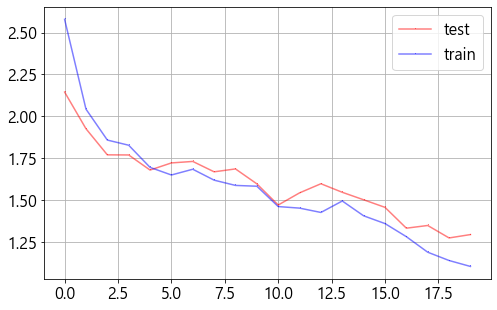

In [6]:
# 테스트 데이터의 오차.
y_vloss = history.history['val_loss']

# 학습 데이터의 오차.
y_loss = history.history['loss']

# 그래프.
x_len = np.arange(len(y_loss))

plt.figure(figsize=(8,5))
plt.plot(x_len, y_vloss, marker=',', c='r', label='test', alpha=0.5)
plt.plot(x_len, y_loss, marker=',', c='b', label='train', alpha=0.5)
plt.legend()
plt.grid()
plt.show()